In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import os
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


from scipy.sparse import csr_matrix
import pandas as pd

[nltk_data] Downloading package words to /home/hasabir/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [9]:
def train(train_df, test_df, vectorizer, model, description):
    with open('../data/raw_splits/train.csv', 'r') as f:
        raw_train_df = pd.read_csv(f)
    
    with open('../data/raw_splits/test.csv', 'r') as f:
        raw_test_df = pd.read_csv(f)

    y_train = raw_train_df['label'].to_numpy().astype(int)
    y_test = raw_test_df['label'].to_numpy().astype(int)
    

    X_train_vector = csr_matrix(train_df.values)
    X_test_vector = csr_matrix(test_df.values)
    
    model.fit(X_train_vector, y_train)
    y_pred = model.predict(X_test_vector)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy for {description}: {accuracy}")
    return accuracy

In [10]:


vectorizers = {
    "TF-IDF": TfidfVectorizer(),
    "Bow": CountVectorizer(binary=False),
    "BinaryVectorizer": CountVectorizer(binary=True),
}

models = {
    "Logistic Regression": LogisticRegression(),
    "MultinomialNB": MultinomialNB(),
    "SVC": SVC(),
}

results = []
for (_, _, train_files), (_, _, test_files) in zip(
    os.walk("../data/prepocessed_training_data"),
    os.walk("../data/prepocessed_testing_data"),
):
    print('i am here')
    for train_file, test_file in zip(train_files, test_files):

        vectorizer_name = train_file.split("_")[-1].replace(".csv", "")
        train_df = pd.read_csv(f"../data/prepocessed_training_data/{train_file}")
        test_df = pd.read_csv(f"../data/prepocessed_testing_data/{test_file}")

        for model_name, model in models.items():
            description = f"{train_file} + {model_name}"
            accuracy = train(train_df, test_df, vectorizers[vectorizer_name], model, description)
            results.append((description, accuracy))


i am here
train file name = tokenization_TF-IDF.csv | test file name = tokenization_TF-IDF.csv
Training tokenization_TF-IDF.csv + Logistic Regression
Accuracy for tokenization_TF-IDF.csv + Logistic Regression: 0.8665730337078652
Training tokenization_TF-IDF.csv + MultinomialNB
Accuracy for tokenization_TF-IDF.csv + MultinomialNB: 0.851123595505618
Training tokenization_TF-IDF.csv + SVC
Accuracy for tokenization_TF-IDF.csv + SVC: 0.8834269662921348
train file name = tokenization_Bow.csv | test file name = tokenization_Bow.csv
Training tokenization_Bow.csv + Logistic Regression
Accuracy for tokenization_Bow.csv + Logistic Regression: 0.8637640449438202
Training tokenization_Bow.csv + MultinomialNB
Accuracy for tokenization_Bow.csv + MultinomialNB: 0.8581460674157303
Training tokenization_Bow.csv + SVC
Accuracy for tokenization_Bow.csv + SVC: 0.851123595505618
train file name = tokenization_BinaryVectorizer.csv | test file name = tokenization_BinaryVectorizer.csv
Training tokenization_Bin

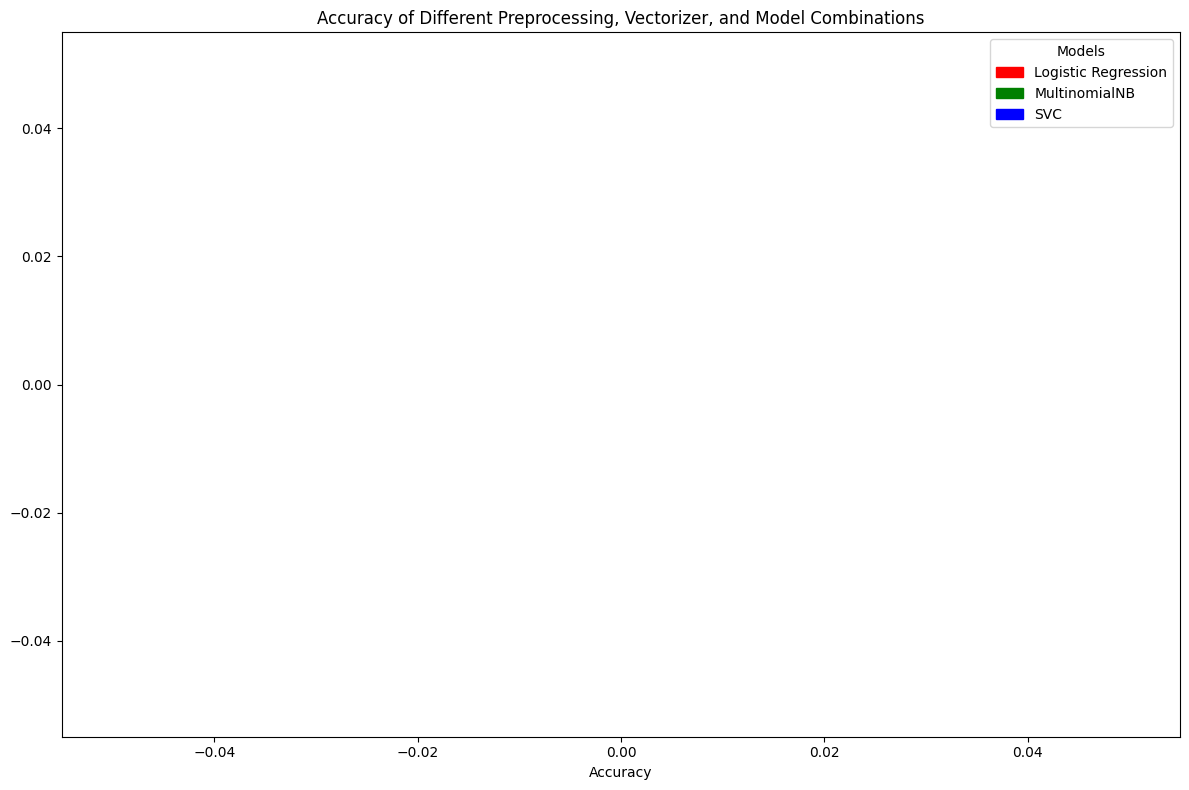

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

results_df = pd.DataFrame(results, columns=["Description", "Accuracy"])
results_df["Model"] = results_df["Description"].apply(lambda x: x.split("+")[-1].strip())

model_colors = {
    "Logistic Regression": "red",
    "MultinomialNB": "green",
    "SVC": "blue",
}

results_df["Color"] = results_df["Model"].map(model_colors)
results_df.sort_values(by="Accuracy", ascending=False, inplace=True)

plt.figure(figsize=(12, 8))
plt.barh(
    results_df["Description"], 
    results_df["Accuracy"], 
    color=results_df["Color"]
)

handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in model_colors.values()]
labels = list(model_colors.keys())

plt.legend(handles, labels, title="Models")
plt.xlabel("Accuracy")
plt.title("Accuracy of Different Preprocessing, Vectorizer, and Model Combinations")
plt.tight_layout()
plt.show()
